In [1]:
import numpy as np
import pandas as pd
import pickle
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import os 
from functions import *
from functools import reduce
from scipy import stats
import itertools
from matplotlib import pyplot as plt

# Genome feature tables from Refseq and Genbank

In [2]:
ref_features = pd.read_csv('../data/genome/GCF_000203855.3_ASM20385v3_feature_table.txt',sep='\t')
ref_features = ( ref_features[ref_features['# feature']=='gene']).reset_index().drop(['index'],axis=1)
ref_features = ref_features[['start','end','strand','feature_interval_length','symbol','locus_tag','attributes']]
ref_features = ( ref_features.dropna(subset=['attributes']) ).reset_index().drop(['index'],axis=1)
ref_features = ref_features.rename(columns = {'locus_tag':'new_locus_tag'})

In [3]:
locus_tag=[]
for i in range(len(ref_features.index)):
    att = list(ref_features['attributes'])[i]
    if 'old_locus_tag=' in str( att ):
        locus_tag.append( str(att.split('=')[1]).strip()  )
    else:
        locus_tag.append('-')
ref_features['locus_tag']=locus_tag
ref_features = ref_features.drop(['attributes'], axis=1)
ref_features['symbol'] = ref_features['symbol'].fillna(ref_features['locus_tag'])
ref_features.head()

,start,end,strand,feature_interval_length,symbol,new_locus_tag,locus_tag
0,1,1368,+,1368,dnaA,LP_RS00005,lp_0001
1,1546,2685,+,1140,dnaN,LP_RS00010,lp_0002
2,3210,3443,+,234,yaaA,LP_RS00015,lp_0004
3,3444,4568,+,1125,recF,LP_RS00020,lp_0005
4,4565,6511,+,1947,gyrB,LP_RS00025,lp_0006


In [4]:
gb_features = pd.read_csv('../data/genome/GCA_000203855.3_ASM20385v3_feature_table.txt',sep='\t')
gb_features = (gb_features[gb_features['# feature']=='gene']).reset_index().drop(['index'],axis=1)
gb_features = gb_features[['start','end','strand','feature_interval_length','symbol','locus_tag']]
gb_features = ( gb_features.dropna(subset=['locus_tag']) ).reset_index().drop(['index'],axis=1)
gb_features['symbol'] = gb_features['symbol'].fillna(gb_features['locus_tag'])
gb_features.head()

,start,end,strand,feature_interval_length,symbol,locus_tag
0,1,1368,+,1368,dnaA,lp_0001
1,1546,2685,+,1140,dnaN,lp_0002
2,3210,3443,+,234,lp_0004,lp_0004
3,3444,4568,+,1125,recF,lp_0005
4,4565,6511,+,1947,gyrB,lp_0006


# Combine transcriptomics

## L. plantarum treated with 3OC12 at three time points(Convert count to RPKM)

In [19]:
GSE124050_ADTV7 = pd.read_csv('../data/transcriptomics/GSE124050_ADTV7.txt',sep='\t')
GSE124050_AYR0M = pd.read_csv('../data/transcriptomics/GSE124050_AYR0M.txt',sep='\t')
GSE124050 = GSE124050_ADTV7.merge( GSE124050_AYR0M, on=['gene'],how='inner')
GSE124050 = GSE124050.rename(columns={'gene':'locus_tag'})
sample_list = list(GSE124050.columns)[1:]
rename_dict = {x: 'wt_3OC_'+x.split('_')[0].strip() for x in sample_list}
GSE124050 = GSE124050.rename(columns = rename_dict )
sample_list = list(GSE124050.columns)[1:]
totalReads = {sample: sum(GSE124050[sample]) for sample in sample_list }
drop_inds = []
for i in range(len( GSE124050.index )):
    if ( list(GSE124050['locus_tag'])[i] not in list(ref_features['locus_tag']) ) and \
        ( list(GSE124050['locus_tag'])[i] not in list(gb_features['locus_tag']) ):
            drop_inds.append(i)
GSE124050 = ( GSE124050.drop(drop_inds) ).reset_index().drop(['index'],axis=1)  
lengths = []
for i in range(len( GSE124050.index )):
    gene_id = list(GSE124050['locus_tag'])[i]
    if gene_id in list(ref_features['locus_tag']):
        temp = ref_features[ref_features['locus_tag'] == gene_id  ]
        lengths.append( list(temp['feature_interval_length'])[0] )
    else:
        temp = gb_features[gb_features['locus_tag'] == gene_id  ]
        lengths.append( list(temp['feature_interval_length'])[0] )       
GSE124050['length'] = lengths

In [23]:
for sample in sample_list:
    temp_rpkm = [ get_rpkm( list(GSE124050[sample])[i],
                    list(GSE124050['length'])[i], totalReads[sample]) for i in range(len(GSE124050.index))]
    GSE124050[sample] = temp_rpkm
GSE124050 = GSE124050[['locus_tag']+sample_list]
print(GSE124050.shape)
GSE124050.head()

(3138, 37)


,locus_tag,wt_3OC_1m1b,wt_3OC_1m4b,wt_3OC_1m7b,wt_3OC_1p1b,wt_3OC_1p4b,wt_3OC_1p7b,wt_3OC_2m1b,wt_3OC_2m4b,wt_3OC_2m7b,...,wt_3OC_2m7,wt_3OC_2p1,wt_3OC_2p4,wt_3OC_2p7,wt_3OC_3m1,wt_3OC_3m4,wt_3OC_3m7,wt_3OC_3p1,wt_3OC_3p4,wt_3OC_3p7
0,lp_0001,411.346138,553.351197,249.371632,209.449487,481.504846,311.347276,402.061680,430.104200,333.087531,...,333.273715,195.250348,543.782304,348.974973,346.797211,635.913367,341.119281,196.448803,448.767525,309.455028
1,lp_0002,675.903244,729.459234,466.167423,350.164700,651.312610,557.832936,604.242954,594.243364,548.100832,...,502.474216,328.605421,665.000442,592.367716,584.858376,2688.804675,578.271646,335.371467,541.017485,515.892220
2,lp_0004,376.813991,357.391046,613.380595,273.134070,540.608405,644.894079,377.668864,367.322540,501.373205,...,576.440654,422.038793,424.975166,558.684419,347.935549,124.605067,418.748057,455.054122,434.364899,615.336113
3,lp_0005,265.064973,257.563170,359.618266,269.134277,250.318908,352.331061,288.394153,264.653997,331.214275,...,352.105323,310.763012,234.571574,342.207692,241.756904,359.569214,297.949608,317.757793,243.216544,359.557490
4,lp_0006,433.302099,440.621223,381.125583,452.061103,379.905628,350.904239,424.262665,471.276575,399.911122,...,424.914035,467.419220,398.212777,369.068335,409.124564,217.431236,440.238369,482.840170,383.178108,357.881465


## L. plantarum strains from nine different habitats

In [30]:
GSE115448 = pd.read_csv('../data/transcriptomics/GSE115448_RPKMvalues.txt',sep='\t')
sample_list = list(GSE115448.columns)[2:]
IDs = []
for i in range(len(GSE115448.index)):
    if 'lp_' in list(GSE115448['GeneSymbol'])[i]:
        IDs.append( list(GSE115448['GeneSymbol'])[i].split(':')[1].strip() )
    elif 'lp_' in list(GSE115448['GeneName'])[i]:
        IDs.append( list(GSE115448['GeneName'])[i].strip() )
    elif list(GSE115448['GeneName'])[i] in list(ref_features['symbol']):
        temp = ref_features[ref_features['symbol'] == list(GSE115448['GeneName'])[i] ]
        IDs.append( list(temp['locus_tag'])[0] )
    elif list(GSE115448['GeneName'])[i] in list(gb_features['symbol']):
        temp = gb_features[gb_features['symbol'] == list(GSE115448['GeneName'])[i] ]
        IDs.append( list(temp['locus_tag'])[0] )
    else:
        IDs.append(list(GSE115448['GeneName'])[i])
GSE115448['locus_tag'] = IDs
GSE115448 = GSE115448.drop(['GeneSymbol','GeneName'], axis = 1)
GSE115448 = GSE115448[['locus_tag']+sample_list]
print(GSE115448.shape)
GSE115448.head()

(3108, 37)


,locus_tag,WCFS1_MRS,LB16_MRS,TJ22,TJ20,TJ19,WFH19,WFH20,WFH1W,PJ16,...,CB5,FEV11_MRS,FEO3_MRS,DE12_MRS,CB5_MRS,OE1_MRS,WFH19_MRS,TJ22_MRS,PJ16_MRS,BEE1ST_MRS
0,repA,190.5490,0.0,0.0,0.0,0.000000,0.282865,0.0,0.000,0.0,...,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
1,orf2,59.9286,0.0,0.0,0.0,0.000000,0.000000,0.0,246.269,0.0,...,33.7182,0.0,0.0,0.0,3.90913,0.0,0.0,0.0,0.0,0.0
2,orf3,116.1010,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,...,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
3,repB,357.2480,0.0,0.0,0.0,0.361062,0.000000,0.0,0.000,0.0,...,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0
4,orf2,203.2870,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000,0.0,...,0.0000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0


## L. plantarum response to acidic conditions

In [29]:
GSE143834 = pd.read_csv('../data/transcriptomics/GSE143834_Lactobacillus_plantarum_gene_expression_pH_.csv')
GSE143834 = GSE143834[['Gene name','Start','End','Strand',
                       'con_1','con_2','pH5.0_1','pH5.0_1.1','pH5.5_1','pH5.5_2']]
GSE143834 = GSE143834.rename(columns={'con_1':'wt_pH6.2_1', 'con_2':'wt_pH6.2_2', 'pH5.0_1':'wt_pH5.0_1',
                                'pH5.0_1.1':'wt_pH5.0_2', 'pH5.5_1':'wt_pH5.5_1', 'pH5.5_2':'wt_pH5.5_2'})
IDs = []
for i in range(len(GSE143834.index)):
    name = list(GSE143834['Gene name'])[i]
    if 'lp_' in name:
        IDs.append(name)
    elif name in list(ref_features['symbol']):
        temp = ref_features[ref_features['symbol'] == name ]
        IDs.append( list(temp['locus_tag'])[0] )
    elif name in list(gb_features['symbol']):
        temp = gb_features[gb_features['symbol'] == name ]
        IDs.append( list(temp['locus_tag'])[0] )
    else:
        IDs.append(name)
GSE143834['locus_tag'] = IDs
GSE143834 = GSE143834[['locus_tag','wt_pH6.2_1','wt_pH6.2_2','wt_pH5.5_1','wt_pH5.5_2',
                       'wt_pH5.0_1','wt_pH5.0_2']]
print(GSE143834.shape)
GSE143834.head()

(3174, 7)


,locus_tag,wt_pH6.2_1,wt_pH6.2_2,wt_pH5.5_1,wt_pH5.5_2,wt_pH5.0_1,wt_pH5.0_2
0,lp_0001,423.10,406.42,468.07,465.00,619.47,640.82
1,lp_0002,672.64,645.10,681.56,685.90,897.24,916.21
2,lp_0004,510.91,559.08,522.82,514.83,499.21,448.14
3,lp_0005,358.58,345.58,294.79,299.09,288.61,290.84
4,lp_0006,437.95,431.14,357.30,361.36,354.50,360.22


## L. plantarum with different carbon sources (Convert count to RPKM)

In [31]:
GSE160565 = pd.read_csv('../data/transcriptomics/GSE160565_raw_gene_count_matrix.txt',sep='\t')
GSE160565 = GSE160565.dropna()
GSE160565 = GSE160565.rename(columns={'Unnamed: 0':'gene'})
sample_list = list(GSE160565.columns)[1:]
sample_names = ["LP_GLC_rep1","LP_GLC_rep2","LP_PAC1_rep1","LP_PAC1_rep2","LP_PAC2_rep1","LP_PAC2_rep2",
                "LP_FOSPAC1_rep1","LP_FOSPAC1_rep2","LP_FOSPAC2_rep1","LP_FOSPAC2_rep2","LP_HMO_rep1",
                "LP_HMO_rep2","LP_HMOPAC1_rep1","LP_HMOPAC1_rep2","LP_HMOPAC2_rep1","LP_HMOPAC2_rep2",
                "LP_XG_rep1","LP_XG_rep2","LP_XGPAC1_rep1","LP_XGPAC1_rep2","LP_XGPAC2_rep1","LP_XGPAC2_rep2"]
rename_dict = {sample_list[i]:sample_names[i].replace('LP','wt') for i in range(len(sample_names))}
GSE160565 = GSE160565.rename(columns=rename_dict)
sample_list = list(GSE160565.columns)[1:]
totalReads = {sample: sum(GSE160565[sample]) for sample in sample_list }
IDs = []
for i in range(len( GSE160565.index )):
    gene_id = list(GSE160565['gene'])[i].split('-')[1].strip()
    if 'RNA' in list(GSE160565['gene'])[i]:
        IDs.append('-')
    elif ( gene_id in list(ref_features['locus_tag']) ) or ( gene_id in list(gb_features['locus_tag']) ):
        IDs.append( gene_id )
    else:
        IDs.append('-')
GSE160565['locus_tag'] = IDs
GSE160565 = GSE160565[GSE160565['locus_tag'] != '-']
lengths=[]
for i in range(len( GSE160565.index )):
    gene_id = list(GSE160565['locus_tag'])[i]
    if gene_id in list(ref_features['locus_tag']):
        temp = ref_features[ref_features['locus_tag'] == gene_id  ]
        lengths.append( list(temp['feature_interval_length'])[0] )
    else:
        temp = gb_features[gb_features['locus_tag'] == gene_id  ]
        lengths.append( list(temp['feature_interval_length'])[0] )       
GSE160565['length'] = lengths

for sample in sample_list:
    temp_rpkm = [ get_rpkm( list(GSE160565[sample])[i],
                    list(GSE160565['length'])[i], totalReads[sample]) for i in range(len(GSE160565.index))]
    GSE160565[sample] = temp_rpkm
GSE160565 = GSE160565[['locus_tag']+sample_list]
print(GSE160565.shape)
GSE160565.head()

(3058, 23)


,locus_tag,wt_GLC_rep1,wt_GLC_rep2,wt_PAC1_rep1,wt_PAC1_rep2,wt_PAC2_rep1,wt_PAC2_rep2,wt_FOSPAC1_rep1,wt_FOSPAC1_rep2,wt_FOSPAC2_rep1,...,wt_HMOPAC1_rep1,wt_HMOPAC1_rep2,wt_HMOPAC2_rep1,wt_HMOPAC2_rep2,wt_XG_rep1,wt_XG_rep2,wt_XGPAC1_rep1,wt_XGPAC1_rep2,wt_XGPAC2_rep1,wt_XGPAC2_rep2
0,lp_0001,310.016351,378.385267,186.335784,181.704531,174.767584,331.888344,274.911717,307.043525,133.515007,...,502.441837,465.934221,223.878364,190.776541,145.272896,114.711457,106.658059,150.624559,168.328237,192.070155
1,lp_0002,669.481193,750.643207,618.965397,640.799551,468.851070,484.447600,459.368611,485.732790,602.754007,...,713.449932,623.604566,609.847872,572.761569,514.850531,449.567228,297.530491,352.205911,553.273363,581.633621
2,lp_0004,987.389048,994.441856,289.907038,324.869788,542.896017,391.251387,465.814018,456.112576,390.274635,...,307.528012,351.971933,528.534823,521.880441,269.890260,310.231795,480.214011,470.846952,397.137958,350.071757
3,lp_0005,114.401974,106.758145,34.261741,33.250165,62.854717,71.754663,190.020699,190.082872,74.980397,...,72.678780,80.916495,124.571592,74.847756,53.047054,90.030381,126.315493,114.415809,69.334865,85.637680
4,lp_0006,87.535495,76.947033,86.446226,82.303207,108.122124,100.719180,395.379766,374.195643,172.343487,...,61.886886,61.782763,102.612308,42.489197,53.565249,114.534706,183.798398,146.368833,60.189621,78.325210


## Merge

In [32]:
# geo_merged = reduce(lambda  left,right: pd.merge(left,right,on=['locus_tag'],
#                             how='inner'), [GSE143834, GSE124050, GSE115448, GSE160565 ])

In [34]:
# geo_merged.to_csv('../data/transcriptomics/merged_rpkm.csv', index = None)

# Log10 transformation and center to reference condition(wt_pH6.2)

In [48]:
geo_merged = pd.read_csv('../data/transcriptomics/merged_rpkm.csv')
log_rpkm = geo_merged.copy()
sample_list = list(geo_merged.columns)[1:]
for sample in sample_list:
    temp_log10 = [ np.log10(  list(geo_merged[sample])[i] + 1  ) for i in range(len(log_rpkm.index)) ]
    log_rpkm[ sample ] = temp_log10
log_rpkm = log_rpkm.set_index(['locus_tag'])
# log_rpkm.to_csv('../data/transcriptomics/log_rpkm.csv')

In [53]:
log_rpkm = pd.read_csv('../data/transcriptomics/log_rpkm.csv',index_col=0)
log_rpkm.head()

,wt_pH6.2_1,wt_pH6.2_2,wt_pH5.5_1,wt_pH5.5_2,wt_pH5.0_1,wt_pH5.0_2,wt_3OC_1m1b,wt_3OC_1m4b,wt_3OC_1m7b,wt_3OC_1p1b,...,wt_HMOPAC1_rep1,wt_HMOPAC1_rep2,wt_HMOPAC2_rep1,wt_HMOPAC2_rep2,wt_XG_rep1,wt_XG_rep2,wt_XGPAC1_rep1,wt_XGPAC1_rep2,wt_XGPAC2_rep1,wt_XGPAC2_rep2
locus_tag,,,,,,,,,,,,,,,,,,,,,
lp_0001,2.627468,2.610042,2.671238,2.668386,2.792721,2.807413,2.615262,2.743785,2.398585,2.323148,...,2.701949,2.669256,2.351948,2.282795,2.165164,2.063376,2.032047,2.180770,2.228729,2.285715
lp_0002,2.828428,2.810300,2.834141,2.836894,2.953392,2.962469,2.830527,2.863596,2.669473,2.545511,...,2.853972,2.795605,2.785933,2.758731,2.712524,2.653760,2.474989,2.548028,2.743724,2.765396
lp_0004,2.709194,2.748250,2.719182,2.712507,2.699152,2.652382,2.577278,2.554357,2.788437,2.437963,...,2.489295,2.547740,2.723895,2.718402,2.432793,2.493084,2.682338,2.673801,2.600034,2.545396
lp_0005,2.555796,2.539803,2.470983,2.477252,2.461814,2.465145,2.424988,2.412567,2.557048,2.431580,...,1.867342,1.913371,2.098891,1.879943,1.732772,1.959186,2.104881,2.062265,1.847171,1.937707
lp_0006,2.642415,2.635624,2.554247,2.559140,2.550840,2.557772,2.637792,2.645050,2.582206,2.656157,...,1.798560,1.797840,2.015411,1.638381,1.736916,2.062712,2.266698,2.168406,1.786678,1.899411


In [55]:
log_rpkm_norm = log_rpkm.sub(log_rpkm[['wt_pH6.2_1','wt_pH6.2_2']].mean(axis=1),axis=0)
# log_rpkm_norm.to_csv('../data/transcriptomics/log_rpkm_norm.csv')
log_rpkm_norm.head()

,wt_pH6.2_1,wt_pH6.2_2,wt_pH5.5_1,wt_pH5.5_2,wt_pH5.0_1,wt_pH5.0_2,wt_3OC_1m1b,wt_3OC_1m4b,wt_3OC_1m7b,wt_3OC_1p1b,...,wt_HMOPAC1_rep1,wt_HMOPAC1_rep2,wt_HMOPAC2_rep1,wt_HMOPAC2_rep2,wt_XG_rep1,wt_XG_rep2,wt_XGPAC1_rep1,wt_XGPAC1_rep2,wt_XGPAC2_rep1,wt_XGPAC2_rep2
locus_tag,,,,,,,,,,,,,,,,,,,,,
lp_0001,0.008713,-0.008713,0.052482,0.049631,0.173965,0.188658,-0.003493,0.125030,-0.220170,-0.295607,...,0.083194,0.050500,-0.266808,-0.335960,-0.453591,-0.555379,-0.586709,-0.437986,-0.390026,-0.333040
lp_0002,0.009064,-0.009064,0.014777,0.017530,0.134029,0.143105,0.011163,0.044232,-0.149891,-0.273853,...,0.034608,-0.023759,-0.033431,-0.060632,-0.106840,-0.165604,-0.344375,-0.271336,-0.075640,-0.053968
lp_0004,-0.019528,0.019528,-0.009540,-0.016215,-0.029569,-0.076340,-0.151444,-0.174365,0.059716,-0.290759,...,-0.239427,-0.180982,-0.004827,-0.010319,-0.295928,-0.235638,-0.046384,-0.054921,-0.128688,-0.183326
lp_0005,0.007996,-0.007996,-0.076816,-0.070548,-0.085986,-0.082655,-0.122812,-0.135233,0.009248,-0.116220,...,-0.680457,-0.634428,-0.448908,-0.667857,-0.815027,-0.588613,-0.442918,-0.485534,-0.700629,-0.610093
lp_0006,0.003395,-0.003395,-0.084773,-0.079880,-0.088180,-0.081248,-0.001228,0.006030,-0.056814,0.017137,...,-0.840460,-0.841179,-0.623608,-1.000638,-0.902104,-0.576307,-0.372322,-0.470614,-0.852342,-0.739609


# Regulons

In [2]:
# def read_regprecise(file):
#     regulon = {}
#     ffile = open(file, "rt")
#     lines = ffile.readlines()
#     ffile.close()
#     for line in lines:
#         line = line.strip()
#         if len(line)<1:
#             continue
#         elif '#' in line:
#             RF = ((line.split(' - ')[1]).split(':')[0]).strip()
#             regulon[ RF ] = []
#         else:
#             g = str(line.split('\t')[1]).strip()
#             regulon[RF].append(g)
#     return regulon 

In [2]:
# regulons={}
# regulons = read_regprecise('../data/IMdata/Regulons_Lplantarum_WCFS1.txt')
# dump_pickle(regulons, '../data/IMdata/lpwcfs1_regulons.pkl')

In [3]:
regulons = load_pickle('../data/IMdata/lpwcfs1_regulons.pkl')
print(regulons.keys())

dict_keys(['NagR', 'Lp_3221', 'PurR', 'CcpA', 'AraR', 'L10_leader', 'TPP', 'FMN', 'PyrR', 'L13_leader', 'L19_leader', 'L20_leader', 'L21_leader', 'Lysine', 'PreQ1', 'Purine', 'Rex', 'glmS', 'ykoK', 'yybP-ykoY', 'T-box(Ala)', 'T-box(Asn)', 'T-box(Asp)', 'T-box(Arg)', 'MntR', 'T-box(Gly)', 'T-box(His)', 'T-box(Ile)', 'T-box(Leu)', 'T-box(Lys)', 'T-box(Met)', 'T-box(Phe)', 'T-box(Ser)', 'T-box(Thr)', 'T-box(Trp)', 'T-box(Tyr)', 'T-box(Val)', 'NiaR', 'GlnR', 'CopR', 'ScrR', 'MalR', 'DeoR', 'MurR', 'CggR', 'PflR', 'NrtR', 'PadR', 'PerR', 'TreR', 'RbsR', 'ArgR', 'GalR', 'HrcA', 'Zur', 'NrdR', 'MtaR', 'CcpB', 'LacR', 'MdxR', 'MalR3', 'GutR', 'MtlR', 'FruR', 'CtsR', 'LexA', 'BirA', 'Lp_2742', 'YtrA', 'YwzG', 'GntR1', 'MleR', 'FlpA', 'NihR', 'FlrR', 'SMK_box_riboswitch', 'YhcF', 'YdfD/YisV'])


# Data Quality

In [5]:
geo_merged = pd.read_csv('../data/IMdata/merged_rpkm.csv')

In [6]:
conversion = {}
for name in list( geo_merged.columns[7:7+37-1] ):
    sample = name.split('3OC_')[1].strip()
    if 'm' in sample:
        cond = 'wt_3OCminus'+str( sample.split('m')[1][0] )+'hr'
    elif 'p' in sample:
        cond = 'wt_3OCpos'+str( sample.split('p')[1][0] )+'hr'
    
    new_name = cond+'_'+sample[0]
    if 'b' in sample:
        new_name = new_name + 'b'
    conversion[name] = new_name 
for name in list( geo_merged.columns[-22:] ):
    conversion[name] = name.replace('rep','')

In [7]:
geo_merged = geo_merged.rename(columns = conversion)

In [8]:
rep_corrs, other_corrs = [],[]
for r1,r2 in itertools.combinations( list( geo_merged.columns[1:7] )+list(conversion.values()),2):
    if r1[:-2] == r2[:-2]:
        rep_corrs.append(stats.pearsonr(geo_merged[r1],geo_merged[r2])[0])
    else:
        other_corrs.append(stats.pearsonr(geo_merged[r1],geo_merged[r2])[0]) 

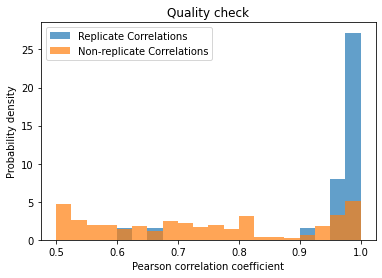

In [11]:
fig,ax = plt.subplots()
ax.hist(rep_corrs,range=(0.5,1),bins=20, density = True,alpha=0.7,label='Replicate Correlations');
ax.hist(other_corrs,range=(0.5,1),bins=20, density = True,alpha=0.7,label='Non-replicate Correlations');
ax.legend()
ax.set_xlabel('Pearson correlation coefficient')
ax.set_ylabel('Probability density')
ax.set_title('Quality check')
# plt.savefig('../../../../ICA_LP/Figures/QC.svg',format='svg',dpi=150)